# Naive Bayes

In this notebook, we build a few Naive Bayes models and evaluate their performance. The key thing to keep in mind is that our data set is imbalanced, with over 87% of the data beloning to Class 0 (i.e. ```r/news```). This makes it hard to gage model performance from accuracy alone.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
from collections import Counter
import joblib

from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, recall_score, precision_score, plot_roc_curve, roc_auc_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, FunctionTransformer, PowerTransformer
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, recall_score, precision_score, f1_score

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from nltk.tokenize import sent_tokenize, word_tokenize, RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer


import thor

# The Baseline Accuracy

In [3]:
train = pd.read_csv('../data/total_train.csv')

X = train.drop(columns='class')['title'].str.lower()
y = train['class']

In [4]:
train.shape

(80329, 3)

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.1, random_state=42) 

- Our baseline accuracy is the score our model would get if it just guessed the majority class for every prediction.


In [6]:
train.value_counts(subset='class', normalize=True)

class
0    0.873196
1    0.126804
dtype: float64

<br>

Notice the imbalance of class distributions: the model can simply cheat and guess ```r/news``` every time, and still have 87.3% accuracy. This is our baseline accuracy and also indicates that accuracy is probably not the single best metric for evaluating our model. Some alternatives metrics include:
1. The Recall Score: how good is the model at detecting ```r/TheOnion``` headlines?
    - Higher recall score means the model is able to detect ```r/TheOnion``` headlines better.
2. The Precision Score: If the model predicts a headline is from ```r/TheOnion```, how likely is it to be correct?
    - Higher Precision Score means the model is not just randomly guessing whether something is from ```r/TheOnion```.
3. The $F_1$-score: combines the previous two metrics via geometric mean.
4. The AUC (Area Under the Curve) of the ROC.


<br>

# Naive Bayes: A Quick Model from 2 Lines of Code

To get us up and running, let's start with a quick and dirty Naive Bayes classifier.

A **Naive Bayes** classifier is a classification model that makes predictions using the principal of Maximum Likelihood. That is, the Naive Bayes classifier will predict that class $y=c$ which maximizes the *likelihood* of the data:
$$P(\text{ data }|y = c)$$

In the context of our problem, Naive Bayes looks at the words $w_1,\ldots, w_n$ inside our document then asks two questions:
1. What is the probability $P(w_1,\ldots, w_n | \text{ news })$ we would see $w_1,\ldots,w_n$ if the document is from ```r/news```?
2. What is the probability $P(w_1,\ldots, w_n | \text{ onion })$ we would see $w_1,\ldots,w_n$ if the document is from ```r/TheOnion```?

Which ever probability is bigger, the model will select that as the predicted class.

The "Naive" part of Naive Bayes comes from how the model actually computes these probabilities. The fact of the matter is: these probabilities are nearly impossible to compute most of the time. Naive Bayes gets around this by simply playing dumb: it *ignores the rules* and *pretends* that the word appearances are all independent (hence the term *naive*).

$$P(w_1,\ldots, w_n | \text{ news })  = c * P(w_1| \text{ news })\ldots  P(w_n| \text{ news })$$
$$P(w_1,\ldots, w_n | \text{ onion })  = c * P(w_1| \text{ onion })\ldots  P(w_n| \text{ onion })$$

where $c$ is some constant that doesn't really matter. The individual conditional probabilities $P(w_1|\text{ onion })$ for example, are estimated using the fraction:

<br>

$$P(w_1|\text{ onion }) = \frac{ \text{ # of docs in Onion containing }w_1}{\text{ # of docs in Onion }}$$

<br>

In order to train our Naive Bayes model (and any model really), we have to first convert our text-based data to numeric data. There are several different ways to do this and each method of conversion leads to different routes of model building. Since we are using Naive Bayes, what we want try first is a **Count Vectorization**. 

A **Count Vectorization** converts a document into a vector where the entries of the vector correspond how to many times a specific word appears in the document. More formally: given a document $D$ and a vocabulary $w_1,\ldots, w_n$, encode the document $D$ as the vector:
$$D\mapsto \langle d_1,d_2,\ldots,d_n \rangle$$
where $d_i$ is the number of times the word $w_i$ appears in $D$.

In [7]:
# create a multinomial naive bayes pipeline with count vectoriz
bayes1 = Pipeline([
                ('cvec', CountVectorizer(stop_words='english')),
                ('mnb', MultinomialNB())
            ])

bayes1.fit(X_train, y_train)    

Pipeline(steps=[('cvec', CountVectorizer(stop_words='english')),
                ('mnb', MultinomialNB())])

In [8]:
bayes1.score(X_train, y_train), bayes1.score(X_test, y_test)

(0.9378388845855926, 0.9163450765591933)

<br>

We achieved a 91.5% accuracy rate on the test set! Not bad for a model we built with only 2 lines of code! 

But our excitement is short-lived once we remember that the baseline accuracy is 87%. This means our model only had about +4.5% higher accuracy than just randomly guessing.
1. On one hand, the the model is showing it's not just randomly guessing.
2. On the other hand, it's not clear to what extent the model has actually learned something interesting.

To answer the question: "has the model found something useful?" we will have to look at the metrics described above:

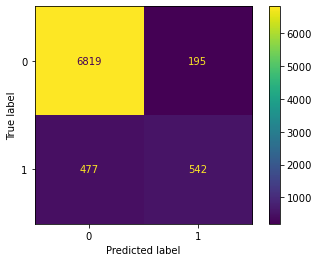

In [9]:
# plot confusion matrix
bayes1_preds = bayes1.predict(X_test)

cm = confusion_matrix(y_test, bayes1_preds)
cmd = ConfusionMatrixDisplay(cm)

cmd.from_predictions(y_test, bayes1_preds);

In [10]:
print("Recall: ", recall_score(y_test, bayes1_preds))
print(" ")
print("Precision: ", precision_score(y_test, bayes1_preds))
print(" ")
print("F1: ", f1_score(y_test, bayes1_preds))
print(" ")

Recall:  0.5318940137389597
 
Precision:  0.7354138398914518
 
F1:  0.6173120728929385
 


C:\Users\herma\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


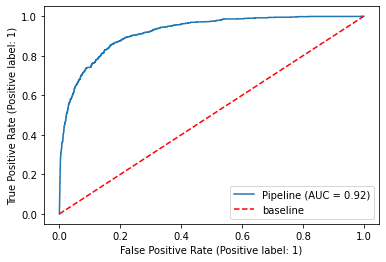

In [11]:
#plot roc curve
plot_roc_curve(bayes1, X_test, y_test);

plt.plot([0,1],[0,1], linestyle='--', color='red', label='baseline');

plt.legend();

<br>

All things considered, things the results are actually pretty decent considering how little we actually did to build this model.
- Recall on the test set is approximately 50%. This means the model is picking up on half of the ```r/TheOnion``` posts.
- Precision on the test set is at 72%. This means the model is decently certain a post is from ```r/TheOnion``` before actually predicting.
- The AUC is at 0.92 and the ROC curve is moderately close to the upper-left corner. The ideal AUC is 1 with a ROC curve that hits the point (0,1).

<br>

---

# Naive Bayes Redux

We can attempt to improve upon the simple Naive Bayes model from before. Let's start by taking a look at some of the misclassified posts.

In [13]:
# false negative posts. These are r/TheOnion posts that were not detected by the model
train_false_negs = X_train[ (y_train==1) & (bayes1.predict(X_train)==0)]

In [14]:
train_false_negs.head(3)

30440    caitlyn jenner sues bruce jenner over sexual h...
50233                     so-called christian has erection
75224                the guardian is back in business boys
Name: title, dtype: object

In [15]:
train_false_negs.iloc[0]

'caitlyn jenner sues bruce jenner over sexual harassment'

- The first post here might actually be a mis-labelled data point since it appears to be a legitimate news headline, but then again that is the whole point of ```r/TheOnion``` and this project.
- As much as we would like to take a closer look at the data, it simply is not feasible to manually inspect all 80,000 news headlines to ensure the labels were correct.

What we can do is take a random sample of headlines and see if anything unusual sticks out.

In [16]:
for text in train_false_negs.sample(n=5, random_state=42):
    print(text)

new netflix gas lets users inhale multiple seasons of tv shows
death penalty for spitting on shopping trolleys in saudi arabia
latest attack: isis just put the pentagon on ebay
everyone in pride parade straight
hey teenage morons, how about you put down 'fortnite' for a sec?


- Some of these headlines seem very difficult to classify even for a human (e.g. the last one).

- The word "new" appears a lot in the false negatives, indicating headlines such as "new medicine cures..." or "new messages reveal..." are tricking the naive Bayes model into thinking they are actual headlines. This isn't surprising since headlines from ```r/TheOnion``` are designed to use common news-type words.
- "Trump" is the second most common term in the false negatives and "Biden" also makes an appearance in the top 20. This indicates that political headlines might be giving the model difficulty.

Anyways, let's try and build a new Naive Bayes model, but this time with some hyperparameter tuning.

In [17]:
pipe2 = Pipeline([
            ('cvec', CountVectorizer()),
            ('mnb', MultinomialNB())
        ])

bayes2_params = {
                    'cvec__ngram_range':[(1,2),(1,3)],
                    'cvec__min_df':[2],
                    'cvec__max_df':[0.3],
                    'cvec__binary':[True]
                }

In [18]:
bayes2 = GridSearchCV(pipe2, bayes2_params, cv=5, n_jobs=8)

bayes2.fit(X_train, y_train)

joblib.dump(bayes2, '../models/mnbayes2.pkl')

bayes2 = joblib.load('../models/mnbayes2.pkl')

In [19]:
bayes2.score(X_train, y_train), bayes2.score(X_test, y_test)

(0.9571622219763196, 0.9274243744553716)

In [20]:
bayes2.best_params_

{'cvec__binary': True,
 'cvec__max_df': 0.3,
 'cvec__min_df': 2,
 'cvec__ngram_range': (1, 3)}

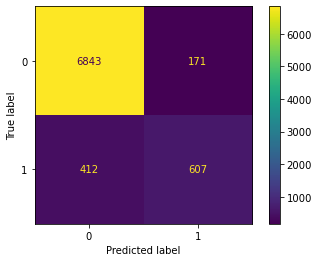

In [21]:
bayes2_preds = bayes2.predict(X_test)

cm2 = confusion_matrix(y_test, bayes2_preds)

cmd.from_predictions(y_test, bayes2_preds);

In [22]:
print("Recall: ", recall_score(y_test, bayes2_preds))
print(" ")
print("Precision: ", precision_score(y_test, bayes2_preds))
print(" ")
print("F1: ", f1_score(y_test, bayes2_preds))

Recall:  0.5956820412168793
 
Precision:  0.7802056555269923
 
F1:  0.6755703951029494


C:\Users\herma\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


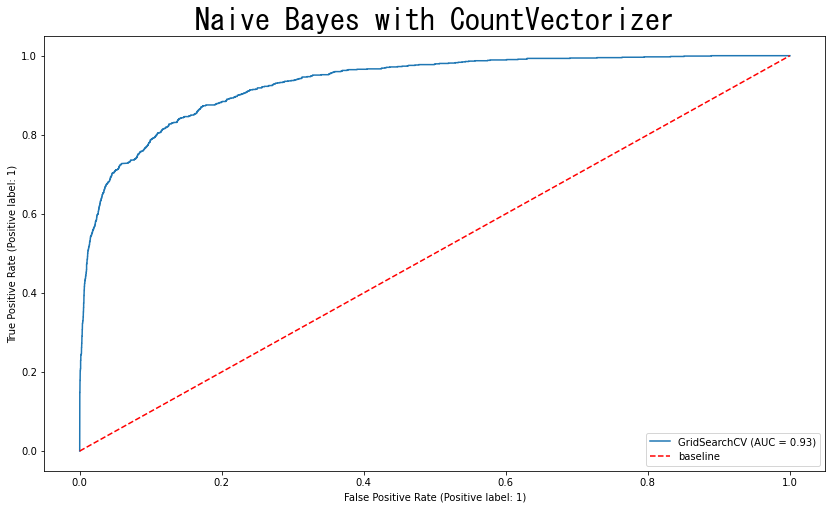

In [23]:
fig, ax = plt.subplots(1, figsize=(14, 8));

plot_roc_curve(bayes2, X_test, y_test, ax=ax);
plt.plot([0,1],[0,1],linestyle='--', color='red', label='baseline');
plt.title('Naive Bayes with CountVectorizer', fontsize=30, font='ms gothic');
plt.legend(loc='lower right');

plt.savefig('../images/bayes2roc.png');

- This model performed surprisingly well, given that Naive Bayes is a rather simplistic model with a tendency to underfit.

---

# Naive Bayes with TF-IDF

Another way to encode text data as a numerical value is with a **TF-IDF** encoding. TF-IDF is short for **Term Frequency - Inverse Document Frequence**. TF-IDF encodes a document via the words they contain (just like Count Vectorizing) but there is an added scaling based on how rare the word is across the corpus. The principle is that rarer words give you more information about the class the document belongs too. For example, seeing the word "hello" doesn't give us too much information since it shows up almost everywhere, but seeing the word "soliloquy" gives us a lot of information since that word is rarely used except in specific contexts.

<br>

In [24]:
# initialize a pipeline with Tfidf encoding
pipe3 = Pipeline([
                    ('tf', TfidfVectorizer()),
                    ('mnb', MultinomialNB())
                ])


bayes3_params = {
                    'tf__ngram_range':[(1,2), (1,3)],
                    'tf__max_df': [0.3],
                    'tf__binary': [True],
                }

In [25]:
bayes3 = GridSearchCV(pipe3, bayes3_params, cv=5, n_jobs=6)

bayes3.fit(X_train, y_train)

joblib.dump(bayes3, '../models/mnbayes3.pkl')

bayes3 = joblib.load('../models/mnbayes3.pkl')

In [26]:
bayes3.score(X_train, y_train), bayes3.score(X_test, y_test)

(0.8813488989708974, 0.8797460475538404)

In [27]:
bayes3.best_params_

{'tf__binary': True, 'tf__max_df': 0.3, 'tf__ngram_range': (1, 3)}

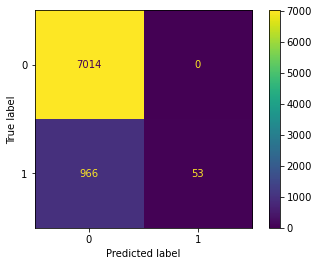

In [28]:
bayes3_preds = bayes3.predict(X_test)

cm3 = confusion_matrix(y_test, bayes3_preds)

cmd.from_predictions(y_test, bayes3_preds);

In [29]:
print("Recall: ", recall_score(y_test, bayes3_preds))
print(" ")
print("Precision: ", precision_score(y_test, bayes3_preds))
print(" ")
print("F1: ", f1_score(y_test, bayes3_preds))

Recall:  0.052011776251226695
 
Precision:  1.0
 
F1:  0.09888059701492538


C:\Users\herma\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


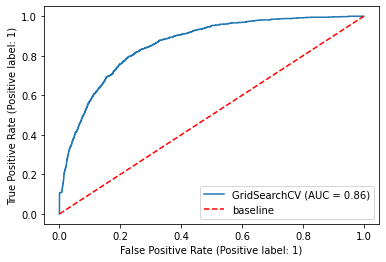

In [30]:
plot_roc_curve(bayes3, X_test, y_test);

plt.plot([0,1],[0,1],linestyle='--', color='red', label='baseline');

plt.legend();

- Seems that using TF-IDF encoding with Naive Bayes actually led to a worse model here. This might not be too surprising since TF-IDF encoding transforms the features to continuous values (floats). This can be a problem since we are using Multinomial Naive Bayes, which obviously works best when the data is Multinomial!

---

# Naive Bayes with Sentiment Analysis

A third approach to encoding text as numeric data is to use **Sentiment Analysis**. Sentiment Analysis assigns each word $w$ in a document $D$ a **polarity score** which measures how "positive" or "negative" the word is. For example "happy" would have a high positive polarity score, while "horror" would have a high negative polarity score. 

The actual polarity scores for each word is decided on by a pre-constructed wordbank, but the key idea is that we can convert a document $D$ from text to numerical data, replacing $D$ with its polarity score $\text{polarity}(D)$. The process of converting a document to a polarity score is called **Sentiment Analysis**.

In [31]:
# convert documents to their polarity score using NLTK's VADER library
Xsia_train = thor.vaderize(X_train)
Xsia_test = thor.vaderize(X_test)

In [32]:
Xsia_train.head()

,neg,neu,pos,compound,text
0,0.524,0.476,0.000,-0.6597,common signs of cervical cancer
1,0.000,1.000,0.000,0.0000,cubana chief priest hires 7 rain makers to sen...
2,0.227,0.567,0.206,-0.0772,a geomagnetic storm may have effectively destr...
3,0.477,0.523,0.000,-0.8481,masten wanjala: mob beats kenyan child serial ...
4,0.231,0.769,0.000,-0.5574,"astro, a founding member of the reggae group u..."


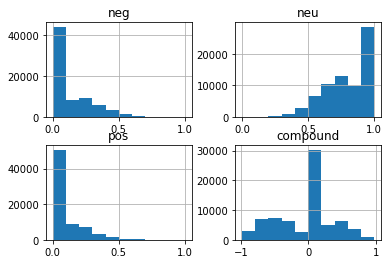

In [33]:
# take a look at polarity score distributions
Xsia_train.hist();

In [34]:
bayes4 = GaussianNB()

bayes4.fit(Xsia_train.drop(columns='text'), y_train)

bayes4.score(Xsia_train.drop(columns='text'), y_train), bayes4.score(Xsia_test.drop(columns='text'), y_test)

(0.8669497620891888, 0.8663015062865679)

Recall:  0.007850834151128557
 
Precision:  0.11267605633802817
 
F1:  0.014678899082568806


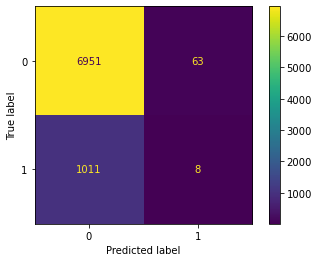

In [35]:
bayes4_preds = bayes4.predict(Xsia_test.drop(columns='text'))

cmd.from_predictions(y_test, bayes4_preds);

print("Recall: ", recall_score(y_test, bayes4_preds))
print(" ")
print("Precision: ", precision_score(y_test, bayes4_preds))
print(" ")
print("F1: ", f1_score(y_test, bayes4_preds))

C:\Users\herma\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


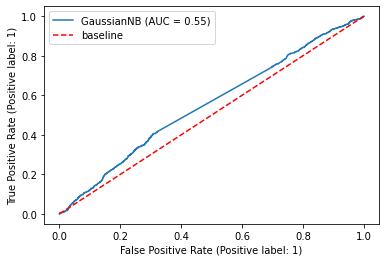

In [36]:
plot_roc_curve(bayes4, Xsia_test.drop(columns='text'), y_test);

plt.plot([0,1],[0,1],linestyle='--', color='red', label='baseline');

plt.legend();

- Looks like doing sentiment analysis was completely useless since the model has the same accuracy as the baseline and is apparntly just randomly guessing. This isn't too unexpected since we are only using 4 features to classify nearly 70,000 training examples.

---

# A Basic Ensemble of Bayes

One final thing we can try is to polymerize the 3 approaches together: Count Vectorization, TF-IDF, and Sentiment Analysis. Ideally, we would try to encode each document as a Count Vector and an TFIDF vector and concatenate them. Unfortunately, the resulting matrix no longer fits into our hardware's memory. 

A work around is to train each model separately, then feed the model outputs into another model like a Logistic Regression (imagine some sort of primordial neural network).

In [37]:
bayes2_train_probs = pd.DataFrame(bayes2.predict_proba(X_train), columns=['bayes2_0', 'bayes2_1'])
bayes2_test_probs = pd.DataFrame(bayes2.predict_proba(X_test), columns=['bayes2_0', 'bayes2_1'])

bayes3_train_probs = pd.DataFrame(bayes3.predict_proba(X_train), columns=['bayes3_0', 'bayes3_1'])
bayes3_test_probs = pd.DataFrame(bayes3.predict_proba(X_test), columns=['bayes3_0', 'bayes3_1'])

bayes2_train_probs.head()

,bayes2_0,bayes2_1
0,0.995674,4.326116e-03
1,0.956854,4.314596e-02
2,1.000000,2.233308e-07
3,0.999915,8.460250e-05
4,1.000000,6.320490e-08


In [38]:
Xens_train = pd.concat([Xsia_train.drop(columns=['text','compound']), bayes2_train_probs[['bayes2_1']], bayes3_train_probs[['bayes3_1']]], axis=1)
Xens_test = pd.concat([Xsia_test.drop(columns=['text', 'compound']), bayes2_test_probs[['bayes2_1']], bayes3_test_probs[['bayes3_1']] ], axis=1)

Xens_test.head()

,neg,neu,pos,bayes2_1,bayes3_1
0,0.112,0.888,0.000,1.000000e+00,0.230683
1,0.000,0.847,0.153,6.424247e-07,0.003483
2,0.000,1.000,0.000,6.058392e-01,0.013713
3,0.178,0.822,0.000,3.392314e-08,0.002908
4,0.000,0.680,0.320,1.011032e-19,0.000017


In [39]:
logreg = LogisticRegression()

logreg.fit(Xens_train, y_train)

logreg.score(Xens_train, y_train), logreg.score(Xens_test, y_test)

(0.9804415182029435, 0.8987924810158098)

C:\Users\herma\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


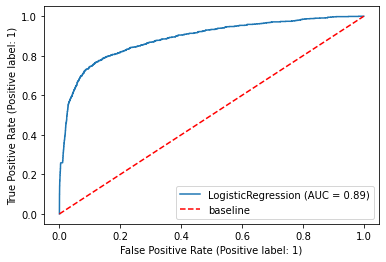

In [40]:
plot_roc_curve(logreg, Xens_test, y_test);
plt.plot([0,1],[0,1],linestyle='--', color='red', label='baseline');

plt.legend()

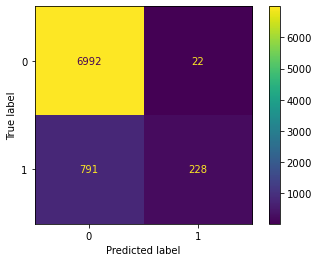

In [41]:
log_preds = logreg.predict(Xens_test)

cmd.from_predictions(y_test, log_preds);

In [42]:
print("Recall: ", recall_score(y_test, log_preds))
print(" ")
print("Precision: ", precision_score(y_test, log_preds))
print(" ")
print("F1: ", f1_score(y_test, log_preds))

Recall:  0.2237487733071639
 
Precision:  0.912
 
F1:  0.35933806146572106


- Overall the pooling of the 3 models is slightly worse than just ```bayes2``` by itself. This suggests that ```bayes2``` is probably the best model and none of the other models have any new knowledge to help improve ```bayes2```.
- Alternatively, because we did pool together 3 distinct models, the resulting combined model might be more robust w.r.t. unseen data.